# Validating a channel model IV curve with data from an experiment

In [1]:
import rickpy
rickpy.use_dev_packages(['scidash/sciunit','scidash/neuronunit'])

# Imports and preliminaries.  
%matplotlib inline
import os,sys
import numpy as np
import quantities as pq

CW_HOME = os.path.split(os.path.realpath(os.path.pardir))[0] # Location of your ChannelWorm repo
sys.path.insert(1,CW_HOME)

from channelworm.fitter.initiators import Initiator

## Compare the IV curve predicted from the channel model to that observed from the data

In [2]:
from neuronunit.tests.channel import IVCurvePeakTest
from neuronunit.models.channel import ChannelModel

In [3]:
# Instantiate the model
channel_model_name = 'EGL-19.channel'
channel_id = 'ca_boyle'
channel_file_path = os.path.join(CW_HOME,'models','%s.nml' % channel_model_name)

model = ChannelModel(channel_file_path,channel_index=0,name=channel_model_name)

In [4]:
# Get the experiment data from ChannelWorm and instantiate the test

import os, sys
import django

sys.path.append(os.path.join(CW_HOME,'channelworm')) # Change the path if needed
os.environ.setdefault(
    "DJANGO_SETTINGS_MODULE",
    "web_app.settings"
)
django.setup()

from channelworm.ion_channel.models import GraphData

doi = '10.1083/jcb.200203055'
fig = '2B'
sample_data = GraphData.objects.get(graph__experiment__reference__doi=doi, graph__figure_ref_address=fig)
obs = list(zip(*sample_data.asarray())) 
observation = {'i/C':obs[1]*pq.A/pq.F, 'v':obs[0]*pq.mV}
cell_capacitance = 1e-13 * pq.F # Capacitance is arbitrary if IV curves are scaled.  
observation['i'] = observation['i/C']*cell_capacitance

test = IVCurvePeakTest(observation, scale=True)

In [5]:
# Judge the model output against the experimental data
score = test.judge(model)
score.summarize()
print("The score was computed according to '%s' with raw value %s and pass cutoff %s" \
    % (score.description,score.raw(),test.converter.cutoff))
print('The scaling factor for the model IV curve was %.3g' % score.related_data['scale_factor'])

=== Model EGL-19.channel achieved score Fail on test 'IV Curve Test'. ===
The score was computed according to 'The sum-squared difference in the observed and predicted current values over the range of the tested holding potentials.' with raw value 3.087 pA**2 and pass cutoff 1.0 pA**2
The scaling factor for the model IV curve was 0.924


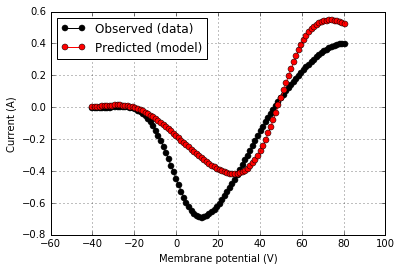

In [6]:
rd = score.related_data
score.plot(rd['v'],rd['i_obs'],color='k',label='Observed (data)')
score.plot(rd['v'],rd['i_pred'],same_fig=True,color='r',label='Predicted (model)')